In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class MultiProductBuyer:
  def __init__(self, n_products, valuation_distribution=(0, 1)):
    self.n_products = n_products
    self.low, self.high = valuation_distribution

  def round(self, prices):
    valuations = np.random.uniform(self.low, self.high, self.n_products)
    purchases = valuations > prices
    rewards = prices * purchases  # Revenue from each product
    return rewards, purchases  # Optionally return purchases to count inventory

In [ ]:
class CombinatorialUCBPricing:
  def __init__(self, price_set, n_products, T, B, range_factor=1):
    self.P = np.array(price_set)
    self.K = len(price_set)
    self.N = n_products
    self.T = T
    self.range = range_factor
    self.B = B
    self.remaining_inventory = B

    # Track avg revenue and counts per (product, price index)
    self.avg_rewards = np.zeros((n_products, self.K))
    self.N_pulls = np.zeros((n_products, self.K))
    self.t = 0

  def pull_arm(self):
    if self.remaining_inventory <= 0:
      return None  # Can't sell anymore

    ucbs = np.zeros_like(self.avg_rewards)
    unexplored_mask = self.N_pulls == 0
    explored_mask = ~unexplored_mask

    ucbs[unexplored_mask] = (1 + self.range * np.sqrt(2 * np.log(self.T))) * np.max(self.P)
    ucbs[explored_mask] = self.avg_rewards[explored_mask] + \
      self.range * np.sqrt(2 * np.log(self.T) / self.N_pulls[explored_mask])

    # Choose best price for each product
    best_price_indices = np.argmax(ucbs, axis=1)
    selected_prices = self.P[best_price_indices]
    self.selected_indices = best_price_indices  # store for update

    return selected_prices

  def update(self, rewards, purchases):
    for i in range(self.N):
      if purchases[i]:
        idx = self.selected_indices[i]
        self.N_pulls[i, idx] += 1
        n = self.N_pulls[i, idx]
        self.avg_rewards[i, idx] += (rewards[i] - self.avg_rewards[i, idx]) / n
        self.remaining_inventory -= 1  # Each sale uses 1 inventory

    self.t += 1

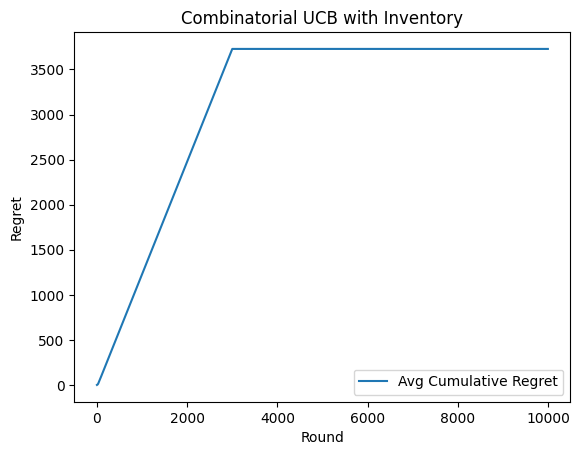

In [ ]:
P = np.linspace(0, 1, 11)
T = 10000
B = 3000  # Inventory
n_products = 5

n_trials = 10
regret_per_trial = []

expected_reward = lambda p: p * (1 - p)
expected_matrix = np.tile(expected_reward(P), (n_products, 1))
clairvoyant_prices_idx = np.argmax(expected_matrix, axis=1)
clairvoyant_prices = P[clairvoyant_prices_idx]
clairvoyant_reward_per_round = np.sum(expected_reward(clairvoyant_prices))
clairvoyant_total_reward = clairvoyant_reward_per_round * min(T, B)

for seed in range(n_trials):
  np.random.seed(seed)
  buyer = MultiProductBuyer(n_products)
  agent = CombinatorialUCBPricing(P, n_products, T, B)
  rewards_log = []

  for t in range(T):
    prices = agent.pull_arm()
    if prices is None:
      break  # No more inventory

    rewards, purchases = buyer.round(prices)
    agent.update(rewards, purchases)
    rewards_log.append(np.sum(rewards))

  cumulative_rewards = np.cumsum(rewards_log)
  T_effective = len(rewards_log)
  clairvoyant_cumulative = np.minimum(np.arange(1, T_effective + 1) * clairvoyant_reward_per_round, clairvoyant_total_reward)
  regret = clairvoyant_cumulative - cumulative_rewards
  regret_per_trial.append(regret)

regret_per_trial = np.array(regret_per_trial)
avg_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(avg_regret, label="Avg Cumulative Regret")
plt.fill_between(np.arange(len(avg_regret)),
                 avg_regret - regret_sd / np.sqrt(n_trials),
                 avg_regret + regret_sd / np.sqrt(n_trials),
                 alpha=0.3)
plt.xlabel("Round")
plt.ylabel("Regret")
plt.title("Combinatorial UCB with Inventory")
plt.legend()
plt.show()